## Exploring 3D Data Augmentations for DeepFindET Training

Data augmentation is a crucial technique in deep learning, particularly when dealing with 3D data like cryo-electron tomography (Cryo-ET) tomograms. Augmentation helps to enhance the diversity of your training dataset, which can lead to more robust and generalizable models. By applying various transformations to your existing data, you can simulate different scenarios that the model might encounter in real-world applications, ultimately improving its performance.

This notebook is designed to help you explore the available 3D data augmentations to train DeepFindET. It provides an interactive environment where you can visualize and experiment with different augmentation strategies. Whether you're working on protein instance segmentation, organelle identification, or any other 3D segmentation task, understanding and applying the right augmentations can significantly impact your model's success.

In the following sections, we will:

**Review the available augmentations**: Gain insights into the different types of augmentations, including geometric transformations, intensity modifications, and noise addition.

**Visualize augmentations**: See how these augmentations alter your tomograms in 3D, helping you to better understand their effects on the data.

**Experiment with parameters**: Adjust augmentation parameters to find the optimal settings for your specific use case.

By the end of this notebook, you should have a solid understanding of how to leverage 3D data augmentations effectively in your deep learning pipelines. Let's dive in and start augmenting!

In [1]:
from deepfindET.utils import copick_tools
from deepfindET.utils import augmentdata
import matplotlib.pyplot as plt
import numpy as np
import copick

In [2]:
def display_images_with_optional_histogram(images, hist_height_ratio=0.3, show_histogram=True):
    """
    Displays three images with an optional combined histogram above them. The histogram plot spans the width of all three images.

    Parameters:
    images (numpy.ndarray): A 3D array of shape (nx, ny, 3) where nx, ny are the dimensions
                            of each image, and 3 represents the three images to be displayed.
    hist_height_ratio (float): The height ratio of the histogram relative to the images. Default is 0.3.
    show_histogram (bool): Whether to display the combined histogram above the images. Default is True.
    """
    if show_histogram:
        # Create a figure with 2 rows: one for the combined histogram and one for the images
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(2, 3, height_ratios=[hist_height_ratio, 1])

        # Create the combined histogram subplot spanning all three columns
        ax_hist = fig.add_subplot(gs[0, :])
        
        # Plot each histogram on the same axis
        colors = ['red', 'green', 'blue']
        for i in range(3):
            ax_hist.hist(images[:, :, i].ravel(), bins=256, color=colors[i], alpha=0.5, label=f'Image {i + 1}')
        ax_hist.legend()

        # Create subplots for each image
        for i in range(3):
            ax_img = fig.add_subplot(gs[1, i])
            ax_img.imshow(images[:, :, i], cmap='gray')
            ax_img.axis('off')  # Hide axes
    else:
        # Create a figure with just one row for the images
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Display each image
        for i in range(3):
            axs[i].imshow(images[:, :, i], cmap='gray')
            axs[i].axis('off')  # Hide axes

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

#### Input Parameters

In [3]:
config = 'config_10439.json'

# Define a specific Run-ID manually. This is useful for extracting volumes for a specific run.
runID = '16186'

# Voxel Size of Tomogram to Extract From
voxel_size = 10

# Protein to Apply 
protein_name = 'ribosome'

#### Retrieve and Prepare the Data

In [4]:
copickRoot = copick.from_file(config)

# Retrieve the specific run object from CoPick using the manually specified Run-ID.
copick_run = copickRoot.get_run(runID)

# Retrieve the tomogram associated with the specified Run-ID from the CoPick project.
# The function get_copick_tomogram extracts the tomogram data, using the voxel size, algorithm, and Run-ID.
tomogram = copick_tools.get_copick_tomogram(
    copickRoot,                 # The root object for the CoPick project, containing all runs and associated data.
    voxelSize=voxel_size,       # The voxel size to be used for retrieving the tomogram.
    tomoAlgorithm='wbp',        # The reconstruction algorithm used for the tomogram, e.g., 'wbp' (weighted back projection).
    tomoID=runID                # The specific Run-ID for which the tomogram is being retrieved.
)

# Query Picks for Ribosome
picks = copick_run.get_picks(object_name="ribosome")[0]

# Initialize Augmentation Class
augment = augmentdata.DataAugmentation(seed=None)

In [5]:
offset = 30
pointIndex = 50

(x,y,z) = (picks.points[pointIndex].location.x, picks.points[pointIndex].location.y, picks.points[pointIndex].location.z) 
(x,y,z) = (int(x/voxel_size), int(y/voxel_size), int(z/voxel_size))

sub_tomo = tomogram[z-offset:z+offset, y-offset:y+offset, x-offset:x+offset]

In [6]:
nIter = 3
(ny,nx) = sub_tomo.shape[1:]
vol_aug = np.zeros([nx,ny,nIter])

### Intensity Transformations

##### Brightness

Brightness adjustment simulates these variations by uniformly increasing or decreasing the voxel intensities. This augmentation helps the model become more robust to inconsistencies in imaging conditions, ensuring accurate segmentation across datasets with different brightness levels.

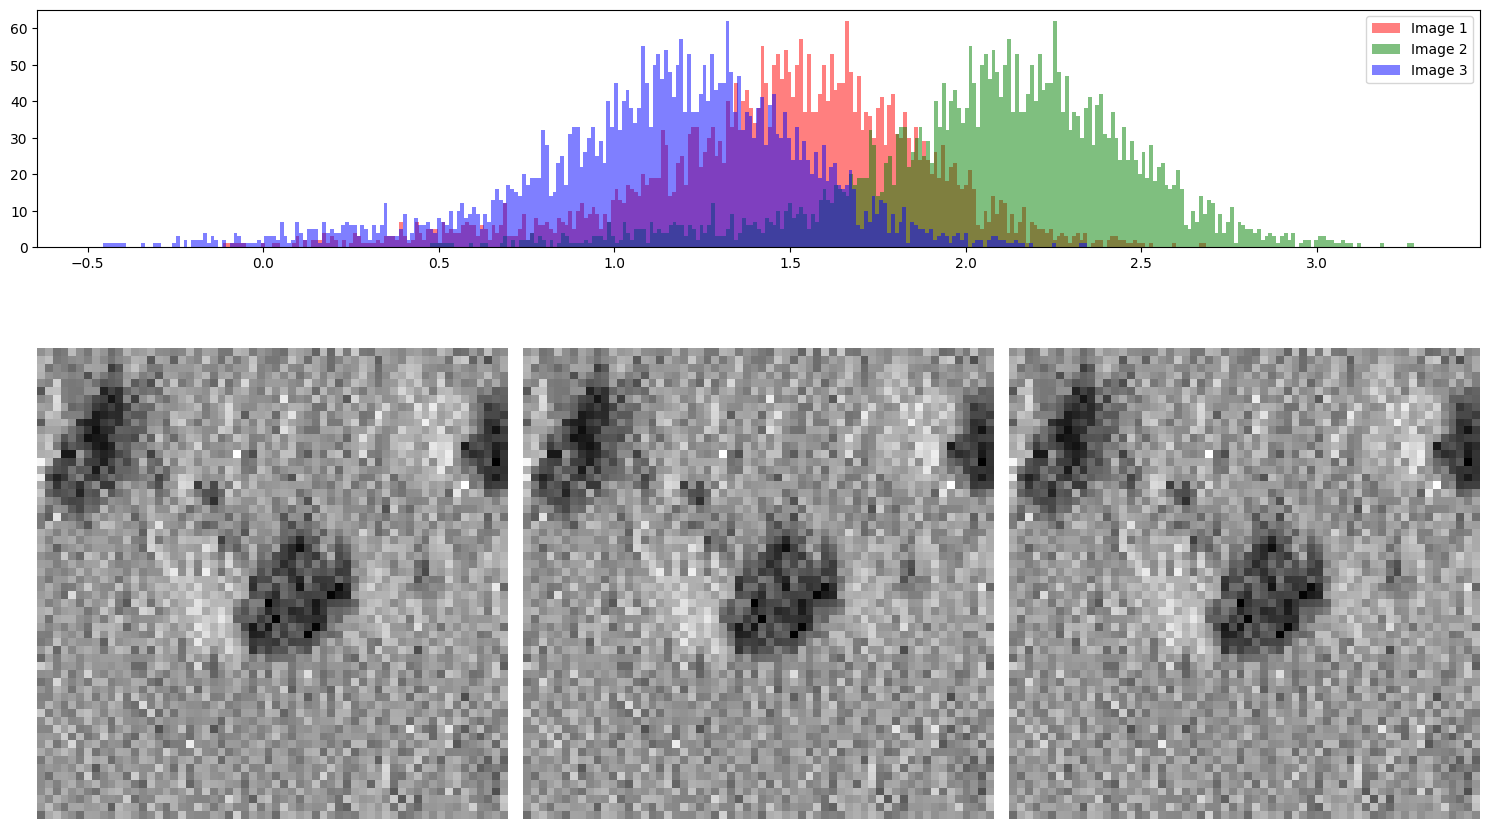

In [104]:
# Default
my_brightness_delta = 1.0

for ii in range(nIter):
    vol_aug[:,:,ii] = augment.brightness(sub_tomo, max_delta = my_brightness_delta)[30,]
display_images_with_optional_histogram(vol_aug)

#### Gaussian Blur
Gaussian blur introduces a controlled amount of blurring to the volume, simulating these effects. By training with blurred data, the model learns to recognize and segment structures even when the images are not perfectly in focus, improving its robustness to variations in image quality.

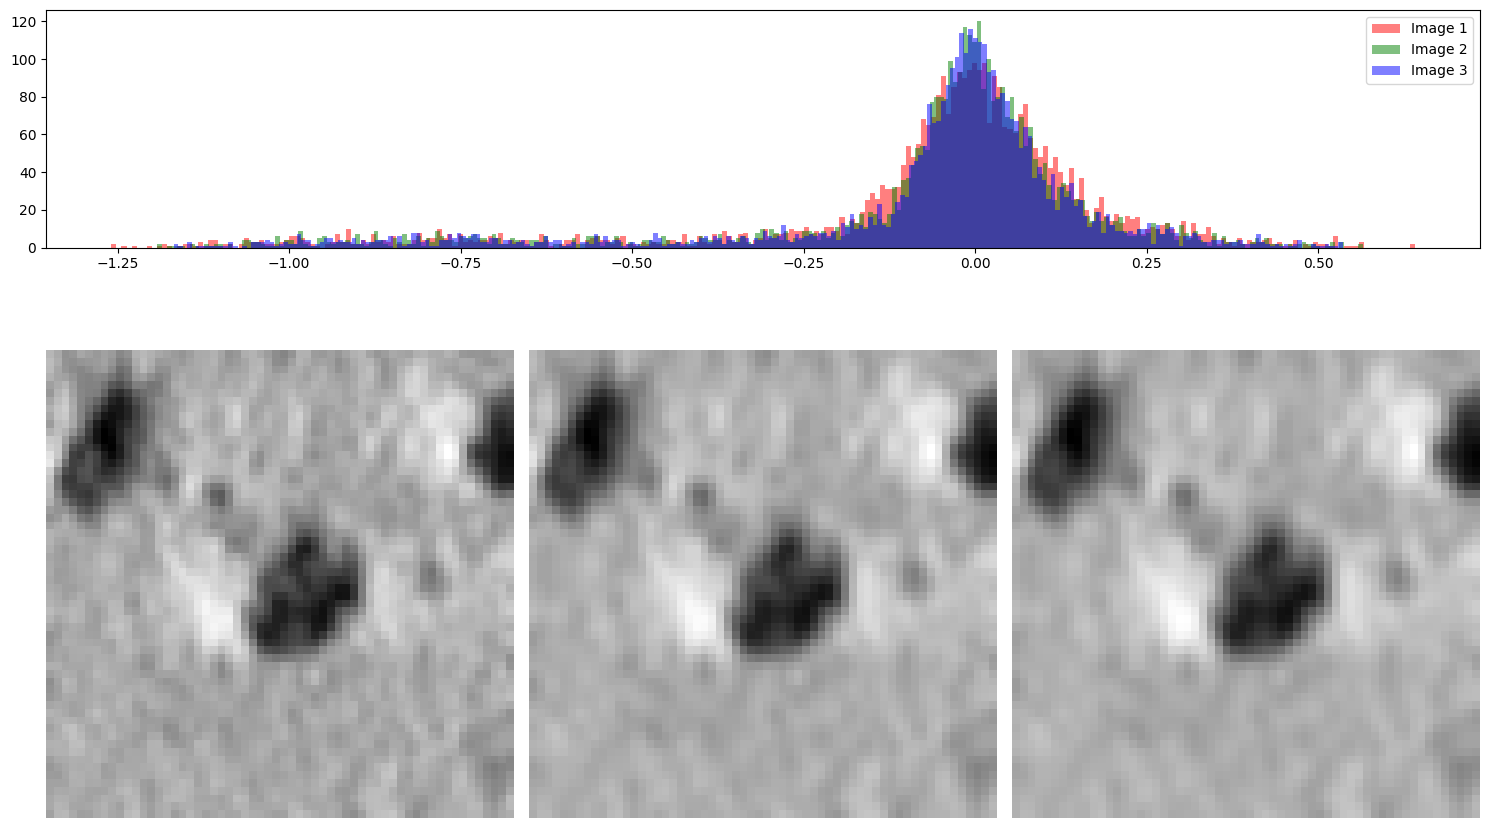

In [7]:
# Default
my_sigma_range = (0.75,1.25)

vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.gaussian_blur(sub_tomo, sigma_range = my_sigma_range)[30,]
display_images_with_optional_histogram(vol_aug)

#### Intensity Scaling

By randomly scaling the intensity of the volume, this augmentation ensures that the model can effectively handle variations in voxel intensity, making it more generalizable to different imaging conditions or datasets.

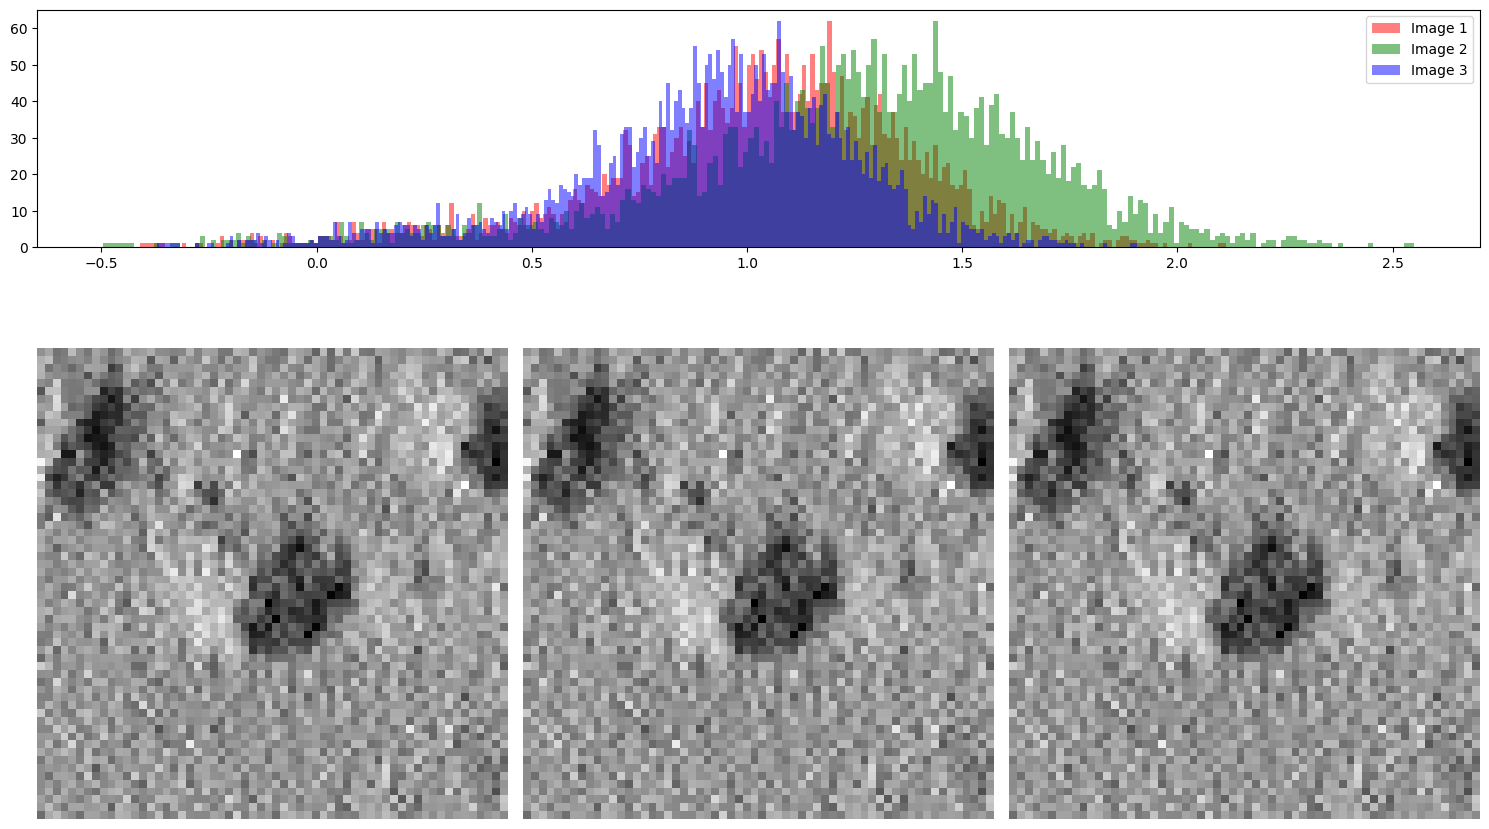

In [106]:
# Default
my_intensity_range = (0.25,1.75)

vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.intensity_scaling(sub_tomo, intensity_range = my_intensity_range)[30,]
display_images_with_optional_histogram(vol_aug)

##### Contrast Adjustment

Contrast adjustment enhances or reduces the difference between light and dark regions in the volume, simulating different levels of contrast. This augmentation helps the model maintain accurate segmentation across datasets with varying contrast, which is crucial for distinguishing between subtle structural details in noisy tomograms.

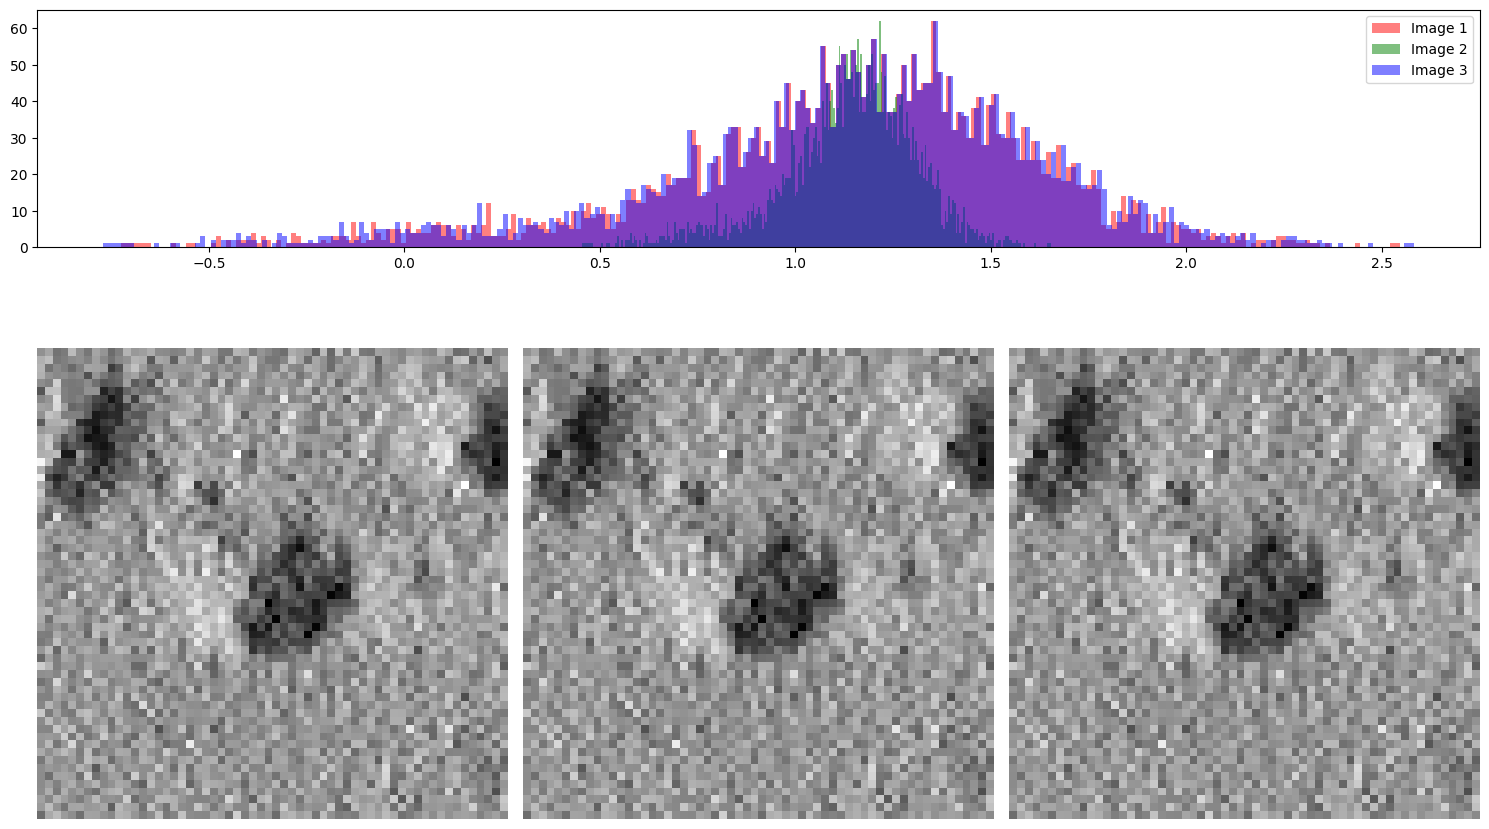

In [107]:
# Default
my_contrast_range = (0.2,1.8) 

vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.contrast_adjustment(sub_tomo, contrast_range = my_contrast_range)[30,]
display_images_with_optional_histogram(vol_aug)

### Geometric Transformations

#### Rotation 180 Degrees

The 180-degree rotation augmentation flips the volume, effectively simulating these orientation changes. This ensures that the model is invariant to such flips, enabling it to segment structures correctly regardless of their orientation in the tomogram.

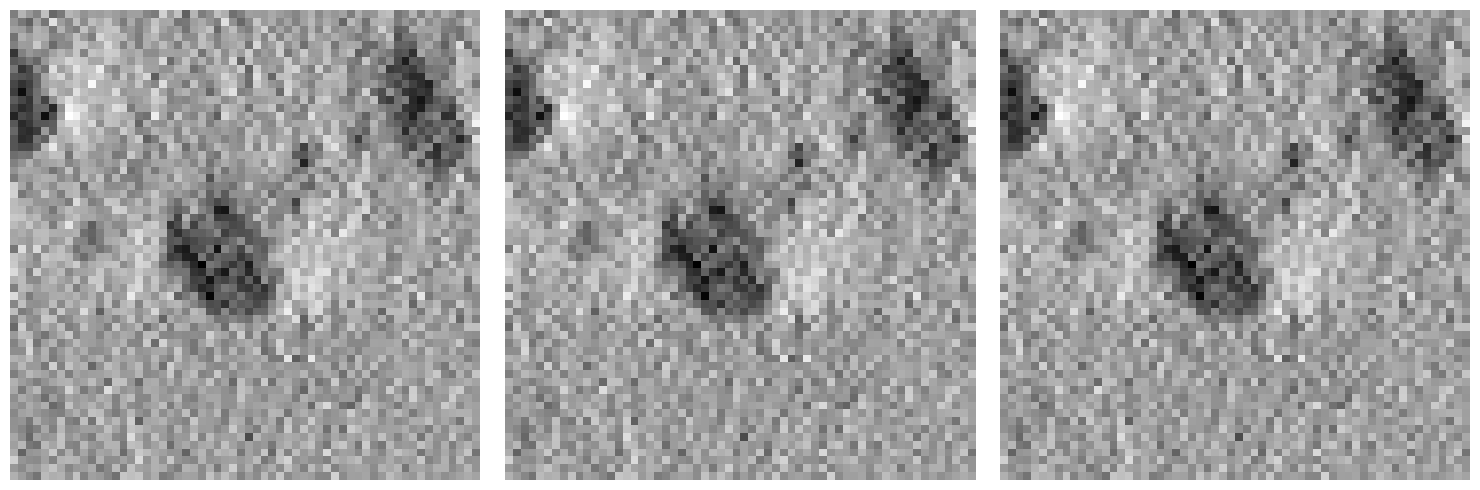

In [109]:
vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.rotation_180_degrees(sub_tomo, np.zeros(sub_tomo.shape), augment_probability = 1.0)[0][30,]
display_images_with_optional_histogram(vol_aug,show_histogram=False)

#### Angle Rotation

This augmentation trains the model to recognize and segment structures accurately, no matter how they are oriented in 3D space, which is particularly important given the diverse and complex nature of cryo-ET datasets.

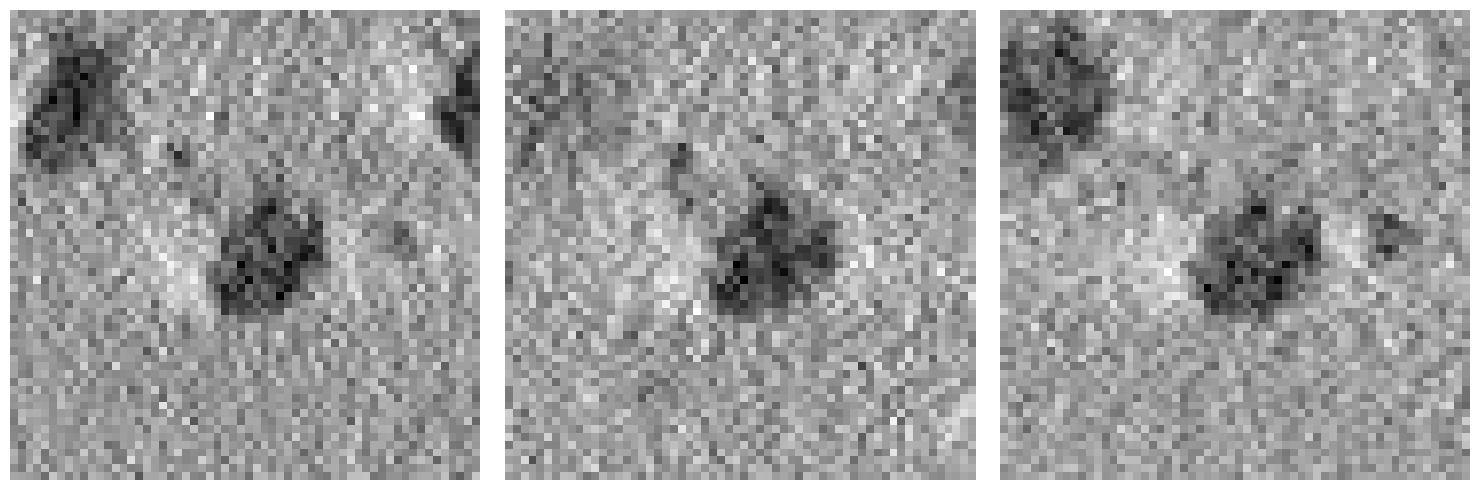

In [111]:
my_scaling_range = (0.8,1.2) # [Default = (0.5,1.5)]

vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.angle_rotation(sub_tomo, np.zeros(sub_tomo.shape), max_angle=30, augment_probability = 1.0)[0][30,]
display_images_with_optional_histogram(vol_aug, show_histogram=False)

##### Elastic Transform

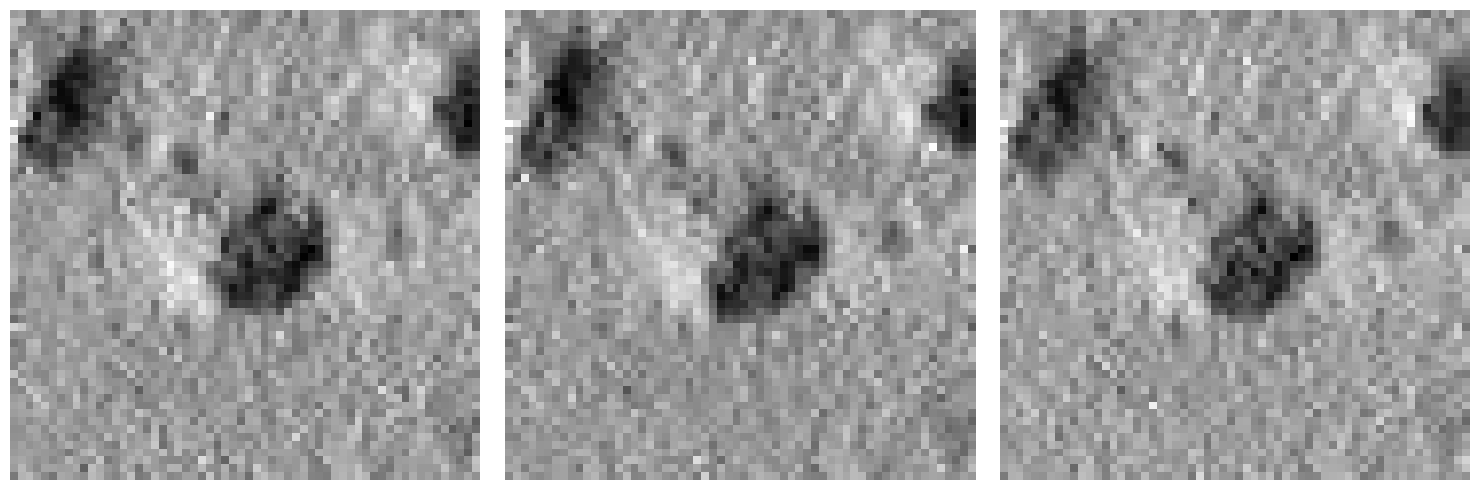

In [112]:
my_scaling_range = (0.8,1.2) # [Default = (0.5,1.5)]

vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.elastic_transform(sub_tomo, np.zeros(sub_tomo.shape), alpha=15, sigma = 2.5)[0][30,]
display_images_with_optional_histogram(vol_aug, show_histogram=False)

#### Now Let's Put All These Augmentations Together

Combining multiple augmentations—such as intensity adjustments and geometric transformations—mimics the diverse conditions encountered in real-world tomograms. This comprehensive approach to augmentation improves the model's ability to generalize across different samples and imaging setups, leading to more reliable and accurate segmentation performance in practical applications.

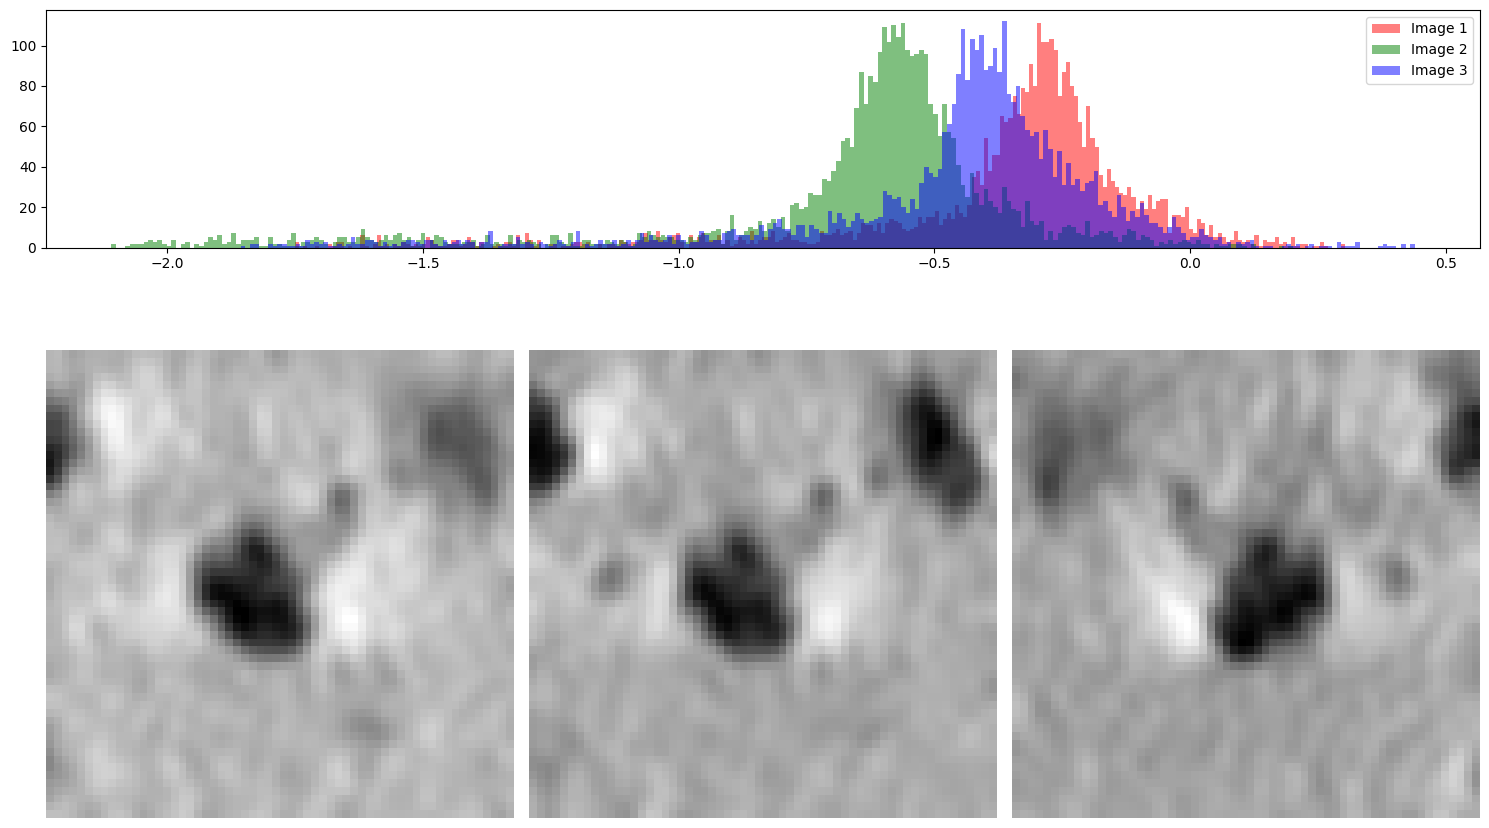

In [8]:
vol_aug[:] = 0
for ii in range(nIter):
    vol_aug[:,:,ii] =  augment.apply_augmentations(sub_tomo, np.zeros(sub_tomo.shape))[0][30,]
display_images_with_optional_histogram(vol_aug)